In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(19)

# loading the MNIST data using this neat library
from mnist import MNIST
data = MNIST('./data')
X_train, Y_train = data.load_training()
X_test, Y_test = data.load_testing()

## Preprocessing

Loading the data and encoding the labels using one-hot encoding.  This is so that we make our output from the NN a 10-d vector whose components correspond to a vector whose ith component is the label i

In [2]:
X_train = np.array(X_train)
X_test = np.array(X_test)

# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing
X_train = X_train/255
X_test = X_test/ 255

print(Y_test[0])
# one-hot-encoding y so that we can compare probability distributions instead of categories
num_classes = 10
targets = np.array(np.array(Y_train)).reshape(-1)
Y_train = np.eye(num_classes)[targets]

targets = np.array(np.array(Y_test)).reshape(-1)
Y_test = np.eye(num_classes)[targets]

7


In [3]:
print(Y_test[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


# 1

## Feed-Forward Neural-Network in NumPy to solve the MNIST Classification problem.

## Foward Pass

First, writing the non-linear activation function, 'sigmoid'.

$$
g(x) = \frac{1}{1+e^{-x}}
$$

In [4]:
g = lambda x: 1/(1+np.exp(-x))

For the output, we want a probability distribution on labels.  These are called logits.  The way we get this is by 'soft-maxing' the output of the final layer.  This is the generalization of sigmoid activation for multi-class problems.  We subtract the max from the numerator and denominator in the code for numerical stability in the code

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^Ne^{x_j}}
$$

In [5]:
softmax = lambda x: np.exp(x-np.max(x,axis=1,keepdims=True))/ \
                    (np.sum(np.exp(x-np.max(x,axis=1,keepdims=True)),axis=1,keepdims=True))

Now we have what we need to create the foward pass algorithm (the neural network), which defines the function approximation, in this case a pmf on labels.

$$
\hat{p}(x) = \text{softmax} \left[ g(g\left[ g(x)w_1 + b_1\right] w_2 + b_2)w_3 + b_3 \right]
$$

I chose a two hidden layer neural network, because this is the architecture we talked about in class when we wanted to approximate bump functions.

In [6]:
def foward_pass(X, W1,W2,W3, b1,b2,b3):
    # in: feature vector X, current weights and biases
    # out: the output from each layer (two hidden layers and an output layer)
    
    # integrate and fire
    L1 = g(np.dot(X, W1) + b1)
    
    L2 = g(np.dot(L1, W2) + b2)
    
    # the output pmf
    L3 = softmax(np.dot(L2, W3) + b3)
    
    return L1,L2,L3

## Backward Pass

Next, defining a cost function (we use this to update the weights in the backpropagation algorithm).  We like to choose a cost function that makes sense with our output units, which live in the space (0,1).  Let's use binary cross entropy which measures the mismatch between our predicted distribution on labels and the true distribution.  This is the standard cost function for this problem and can be motivated by an information theory perspective.

$$
C(w) = H(p,\hat{p})  = \frac{-1}{\text{# samples}}\sum_{i} p_i \log \hat{p}_i(w)
$$

In [7]:
def cost_fcn(Y_pred, Y_true):
    # for numerical stability
    eps = np.finfo(float).eps
    Y_pred = np.clip(Y_pred, eps, 1. - eps)
    cost = - np.mean(np.log(Y_pred) * Y_true) 
    return cost

We also need some additional gradient functions for the updating procedure.  When we actually use g', the input is already the output g from the last layer, so we don't reapply sigmoid.

In [8]:
g_prime = lambda gx: gx*(1-gx)

When you find the update rule (the derivative of the cost with respect to the weights), a lot of things cancel when using binary cross entropy and softmax together.  The following is the gradient for the last output.

In [9]:
cost_prime = lambda Y_true, Y_pred: (Y_pred-Y_true)/Y_true.shape[0]

Now we're ready to define the backpropagation algorithm, which is the way we optimize these weights.

First note the network:
$$
l_1 = g(xw_1 + b_1)\\
l_2 = g(l_1w_2 + b_2)\\
l_3 = \text{softmax}(l_2w_3 + b_3)\\
$$
So recursively taking the gradients:
$$
\Delta l_3 = \frac{\partial C}{\partial w_3} = l_3 - y _{\text{true}} \\
\Delta l_2 = \frac{\partial l_3}{\partial w_2} = \Delta l_3 w_3 g'(l_2) \\
\Delta l_1 = \frac{\partial l_2}{\partial w_1} = \Delta l_2 w_2 g'(l_1)
$$

In [10]:
def backward_pass(X, Y, W1,W2,W3, b1,b2,b3, L1,L2,L3):
    # Input: outputs from forward pass
    # Output: the updated weights, biases from gradient descent

    learning_rate = .5
    # computing the partials for the last layer, which is used for the next, and so on
    L3_delta = cost_prime(L3, Y)
    
    #played around with the dots and the transposes until I got the desired dimensions
    W3 = W3 + learning_rate * np.dot(L2.T, L3_delta)
    b3 = b3 + learning_rate * np.sum(L3_delta, axis = 0, keepdims = True)
    
    # next down
    L2_delta = np.dot(L3_delta, W3.T) * g_prime(L2) 
    W2 = W2 + learning_rate * np.dot(L1.T, L2_delta)
    b2 = b2 + learning_rate * np.sum(L2_delta, axis = 0)
    
    #first layer
    L1_delta = np.dot(L2_delta, W2.T) * g_prime(L1) 
    W1 = W1 + learning_rate * np.dot(X.T, L1_delta)
    b1 = b1 + learning_rate * np.sum(L1_delta, axis = 0)
    
    return W1,W2,W3, b1,b2,b3

## Initializing the Net

I chose a random initialization and a hidden size of 128 neurons.

In [11]:
dim_sz = 128

in_sz = X_train.shape[1]
out_sz = Y_train.shape[1]

W1 = np.random.randn(in_sz, dim_sz)
b1 = np.zeros((1, dim_sz))

W2 = np.random.randn(dim_sz, dim_sz)
b2 = np.zeros((1, dim_sz))

W3 = np.random.randn(dim_sz, out_sz)
b3 = np.zeros((1, out_sz))

## Training

Optimizing the weights through gradient descent.

In [12]:
epochs = 1000
training = np.zeros(epochs)
for epoch in range(epochs):
    L1,L2,L3 = foward_pass(X_train, W1,W2,W3, b1,b2,b3)
    curr_cost = cost_fcn(L3,Y_train)
    if epoch % 100 == 0:
        print('epoch = {} | cost = {}'.format(epoch, curr_cost))
    training[epoch] = curr_cost
    W1,W2,W3, b1,b2,b3 = backward_pass(X_train, Y_train, W1,W2,W3, b1,b2,b3, L1,L2,L3)

epoch = 0 | cost = 0.8429628346288437
epoch = 100 | cost = 0.08870297715786424
epoch = 200 | cost = 0.06633111300105028
epoch = 300 | cost = 0.05643794296255471
epoch = 400 | cost = 0.05043641834047603
epoch = 500 | cost = 0.04623390500561551
epoch = 600 | cost = 0.04304648717000773
epoch = 700 | cost = 0.040501588263851765
epoch = 800 | cost = 0.03839871869674471
epoch = 900 | cost = 0.03661765489057807


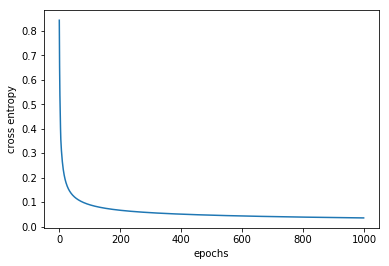

In [13]:
plt.plot(training)
plt.xlabel('epochs')
plt.ylabel('cross entropy');

## Testing

In [14]:
L1,L2,L3 = foward_pass(X_test, W1,W2,W3, b1,b2,b3)

acc = 0
for x,y in zip(X_test, Y_test):
    L1,L2,L3 = foward_pass(x, W1,W2,W3, b1,b2,b3)
    s = L3.argmax()
    # if s is the right label, increase accuracy
    if s == np.argmax(y):
        acc = acc + 1
accuracy = acc/len(X_test)*100
print("accuracy on testing data: ", accuracy)

accuracy on testing data:  88.75


# 2

## Convolutional Neural Net in TensorFlow for the MNIST Classification Problem

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from datetime import datetime
import os
#visualization library
from tensorflow.python.keras.callbacks import TensorBoard

tf.random.set_seed(194)

## Preprocessing

In [16]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing
X_train = X_train/255
X_test = X_test/ 255

# LeNet-5 accepts 32 by 32 image, so to make it work with the given 28 by 28 image, I pad with zeros
X_train = np.pad(X_train,((0,0),(2,2),(2,2),(0,0)),'constant')
X_test = np.pad(X_test,((0,0),(2,2),(2,2),(0,0)),'constant')

## Forward Pass

I chose to use LeCunn's LeNet-5.  It accepts a 32 by 32 pixel image and returns a 10-d vector of values in (0,1) which corresponds to labels.  It consists of two convolutional layers, each of which uses average pooling to downsample and cut the number of parameters down, and two fully connected hidden layers. Tensorflow is Object Oreintated, so I instantiate a model object instead of writing things procedurally as I did before

<img src="LeNet_Original_Image.jpg" width=500 height=500 />

LeCun et al., 1998

In [17]:
# this model keeps track of all the weights and biases under the hood
model = models.Sequential()

# conv1
model.add(layers.Conv2D(filters = 6, kernel_size=(3, 3), activation='relu', input_shape= (32,32,1)))
# downsample the image
model.add(layers.AveragePooling2D())

#conv2 
model.add(layers.Conv2D(filters = 16, kernel_size=(3, 3), activation='relu'))
# downsample
model.add(layers.AveragePooling2D())

# just flatten the last tensor into vector
model.add(layers.Flatten())

# fully connected layers
model.add(layers.Dense(units = 120, activation='relu'))

model.add(layers.Dense(units = 84, activation='relu'))

model.add(layers.Dense(units = 10, activation = 'softmax'))

# visualize schematically
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

## Backward Pass

Compiling the underlying computation graph and optimizing weights via backpropagation with Adam, which is a popular type of Stochastic Gradient Descent algorithm.  (It's Gradient Descent, but updates in batches of samples instead of using all at once, so it's stochastically marching down the loss function.  It also uses other parameters such as momentum).  We're trying to minimize cross entropy again.

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Using tensorboard to visualize the loss and accuracy over time

In [19]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Training

In [20]:
model.fit(x = X_train,y = Y_train, epochs=10, callbacks = [tensorboard_callback])

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 22s 366us/sample - loss: 0.2111 - accuracy: 0.9357
Epoch 2/10
60000/60000 [==============================] - 21s 345us/sample - loss: 0.0685 - accuracy: 0.9792
Epoch 3/10
60000/60000 [==============================] - 20s 338us/sample - loss: 0.0491 - accuracy: 0.9847
Epoch 4/10
60000/60000 [==============================] - 20s 338us/sample - loss: 0.0393 - accuracy: 0.9877
Epoch 5/10
60000/60000 [==============================] - 21s 356us/sample - loss: 0.0312 - accuracy: 0.9901
Epoch 6/10
60000/60000 [==============================] - 20s 333us/sample - loss: 0.0249 - accuracy: 0.9922
Epoch 7/10
60000/60000 [==============================] - 19s 316us/sample - loss: 0.0224 - accuracy: 0.9930
Epoch 8/10
60000/60000 [==============================] - 19s 319us/sample - loss: 0.0183 - accuracy: 0.9941
Epoch 9/10
60000/60000 [==============================] - 19s 313us/sample - loss: 0.0160 - accuracy: 0.9

In [21]:
%load_ext tensorboard
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6008 (pid 2963), started 0:53:04 ago. (Use '!kill 2963' to kill it.)

## Testing

In [22]:
model.evaluate(X_test, Y_test);

10000/10000 [==============================] - 2s 177us/sample - loss: 0.0421 - accuracy: 0.9892
